## Setup and Dependencies

In [ ]:
# --- Extension Setup ---
%load_ext line_profiler
%load_ext autoreload

%autoreload 2 -p

# --- Autoreload Target ---
%aimport afml

# --- Module Imports ---
import sys

sys.path.append("..")  # Adjust if your afml repo is nested differently

# Ensure models render in notebook
from sklearn import set_config

set_config(display="text")

from loguru import logger
from tqdm import tqdm

# Define a sink that uses tqdm.write
def tqdm_sink(msg):
    tqdm.write(msg, end="")  # end="" avoids double newlines

# Remove default handler and add our custom one
logger.remove()
logger.add(
    tqdm_sink,
    format="<green>{time:YYYY-MM-DD HH:mm:ss:ms}</green> | "
           "<level>{level: <8}</level> | "
           "<cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - "
           "<level>{message}</level>",
    colorize=True
)


2025-12-16 11:13:55.283 | DEBUG    | afml.cache:<module>:687 - Enhanced cache features available:
2025-12-16 11:13:55.284 | DEBUG    | afml.cache:<module>:688 -   - Unified cacheable() decorator with auto_versioning
2025-12-16 11:13:55.285 | DEBUG    | afml.cache:<module>:689 -   - Robust cache keys for NumPy/Pandas
2025-12-16 11:13:55.287 | DEBUG    | afml.cache:<module>:690 -   - MLflow integration: ✓
2025-12-16 11:13:55.290 | DEBUG    | afml.cache:<module>:691 -   - Backtest caching: ✓
2025-12-16 11:13:55.295 | DEBUG    | afml.cache:<module>:692 -   - Cache monitoring: ✓
2025-12-16 11:13:55.296 | DEBUG    | afml.cache:<module>:693 -   - Orphaned cache cleanup: ✓
2025-12-16 11:13:56.166 | DEBUG    | afml.cache:_configure_numba:59 - Numba cache configured: C:\Users\JoeN\AppData\Local\afml\afml\Cache\numba_cache
2025-12-16 11:13:56.167 | INFO     | afml.cache:initialize_cache_system:245 - AFML cache system initialized:
2025-12-16 11:13:56.168 | INFO     | afml.cache:initialize_cache_sy

In [ ]:
import re
import time
import warnings
import winsound
from pathlib import Path
from pprint import pformat, pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
)
from tqdm import tqdm

from afml.cross_validation import (
    PurgedKFold,
    PurgedSplit,
    analyze_cross_val_scores,
    analyze_cross_val_scores_calibrated,
    probability_weighted_accuracy,
)
from afml.data_structures.bars import *
from afml.ensemble import (
    SequentiallyBootstrappedBaggingClassifier,
    compute_custom_oob_metrics,
    estimate_ensemble_size,
)
from afml.labeling.triple_barrier import (
    add_vertical_barrier,
    get_event_weights,
    triple_barrier_labels,
)
from afml.production.model_development import (
    calculate_rolling_metrics,
    create_feature_engineering_pipeline,
    generate_events_triple_barrier,
    load_and_prepare_training_data,
)
from afml.sample_weights.optimized_attribution import (
    get_weights_by_time_decay_optimized,
)
from afml.strategies import (
    BollingerStrategy,
    ForexFeatureEngine,
    MACrossoverStrategy,
    create_bollinger_features,
    get_entries,
)
from afml.util import get_daily_vol, value_counts_data, dict_to_key, expand_params

warnings.filterwarnings("ignore")
# plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("dark_background")


In [ ]:
# from afml.cache import clear_data_access_log, clear_afml_cache


# clear_afml_cache()
# clear_data_access_log()


## 0. Data Collection and Cleaning

In [ ]:
symbol = "EURUSD"
start_date = "2022-01-01"
end_date = "2023-12-31"
account_name = "FUNDEDNEXT_STLR2_6K"
bar_type = "time"
bar_size = "M5"
price = "mid_price"


In [ ]:
df = load_and_prepare_training_data(
    symbol,
    start_date,
    end_date,
    account_name,
    bar_type,
    bar_size,
    price,
)
df.info()


2025-12-16 11:14:06.234 | DEBUG    | afml.cache.unified_cache_system:track_cache_call:574 - Cache HIT: afml.production.model_development.load_and_prepare_training_data (key: c09c4258...)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 147860 entries, 2022-01-03 00:05:00 to 2023-12-29 23:00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   open         147860 non-null  float32
 1   high         147860 non-null  float32
 2   low          147860 non-null  float32
 3   close        147860 non-null  float32
 4   spread       147860 non-null  float32
 5   spread_bps   147860 non-null  float32
 6   tick_volume  147860 non-null  int16  
 7   tick_num     147860 non-null  int32  
dtypes: float32(6), int16(1), int32(1)
memory usage: 5.4 MB


## 1. Bollinger Band Strategy

### Time-Bars

In [ ]:
from scipy.stats import randint, uniform

feature_configs = dict(bb_period=np.arange(5, 35, 2), bb_std=np.arange(1.5, 2.1, 0.1))

data_configs = dict(
    account_name=[account_name],
    bar_type=["time", "tick"],
    bar_size=["M1"],
    price=["mid_price"],
)
pt_sl_ = np.arange(0.5, 2.5, 0.5)
label_configs = dict(
    target_lookback=[3, 5, 7, 10, 20, 30, 50, 100],
    profit_target=[1],
    stop_loss=[2],
    max_holding_period=[
        dict(days=1),
        dict(days=2),
        dict(days=3),
        dict(days=5),
    ],  # dict(num_bars=100),
    min_ret=[0],
    vertical_barrier_zero=[True],
)


#### Model Params

In [ ]:
clf = RandomForestClassifier(
    criterion="entropy",
    class_weight="balanced_subsample",
    random_state=42,
)
name = "clf"
param_grid = {
    f"{name}__n_estimators": randint(50, 500),  # sample integers between 100 and 500
    f"{name}__max_depth": randint(3, 7),  # sample integers between 3 and 6
    f"{name}__min_samples_split": randint(2, 20),
    f"{name}__min_samples_leaf": randint(1, 10),
    f"{name}__max_features": uniform(0.1, 0.9),
    f"{name}__min_weight_fraction_leaf": uniform(0.05, 0.45),
}


In [ ]:
model_params = dict(
    pipe_clf=clf,
    param_grid=param_grid,
    cv_splits=5,
    bagging_n_estimators=0,
    bagging_max_samples=1,
    bagging_max_features=1,
    rnd_search_iter=20,
    n_jobs=-1,
    pct_embargo=0.01,
    random_state=42,
    verbose=False,
)


#### Develop Production Model

In [ ]:
from collections import namedtuple

from afml.production.model_development import ModelDevelopmentPipeline

data_config = expand_params(data_configs)[0]

# feature_cfg = expand_params(feature_config)[0]
feature_config = {
    "func": create_bollinger_features,
    "params": dict(window=10, std=1.5),
}

label_config = dict(
    target_lookback=10,
    profit_target=1,
    stop_loss=2,
    max_holding_period=dict(days=1),
    min_ret=0,
    vertical_barrier_zero=True,
    filter_as_series=False,
)

strategy = BollingerStrategy(**feature_config["params"])
strategy_cfg = label_config.copy()
strategy_cfg["strategy"] = strategy.get_strategy_name()


train_start = start_date
train_end = end_date
training_cfg = dict(train_start=train_start, train_end=train_end)


In [ ]:
# pipeline = ModelDevelopmentPipeline(
#     symbol=symbol,
#     train_start=train_start,
#     train_end=train_end,
#     strategy=strategy,
#     data_config=data_config,
#     feature_config=feature_config,
#     label_config=label_config,
#     model_params=model_params,
# )
# best_model, model_features, metrics, config = pipeline.run()


In [ ]:
trained_models = {}


In [ ]:
TrainedModel = namedtuple(
    "TrainedModel", ["model", "model_features", "metrics", "config", "pipeline"]
)
keyify = dict_to_key()

for data_config in expand_params(data_configs):
    training_cfg.update(data_config)
    outer_key = keyify(training_cfg)
    inner_key = keyify(strategy_cfg)
    trained_models.setdefault(outer_key, {})
    trained_models.setdefault(inner_key, {})
    if not trained_models[outer_key].get(inner_key):
        pipeline = ModelDevelopmentPipeline(
            symbol=symbol,
            train_start=train_start,
            train_end=train_end,
            strategy=strategy,
            data_config=data_config,
            feature_config=feature_config,
            label_config=label_config,
            model_params=model_params,
        )

        best_model, model_features, metrics, config = pipeline.run()
        trained_models[outer_key][inner_key] = TrainedModel(
            best_model, model_features, metrics, config, pipeline
        )

winsound.Beep(1000, 1000)


2025-12-16 11:14:08 | afml.production.model_development | INFO | Starting pipeline for EURUSD
2025-12-16 11:14:08 | afml.production.model_development | INFO | Training period: 2022-01-01 to 2023-12-31
2025-12-16 11:14:08 | afml.production.model_development | INFO | Output directory: Models\Bollinger_w10_std1_5\EURUSD\FUNDEDNEXT_STLR2_6K\time\M1\20220101_20231231\bdad004f

PRODUCTION MODEL DEVELOPMENT PIPELINE

Configuration
--------------------------------------------------
strategy                 Bollinger_w10_std1.5
symbol                                 EURUSD
training_start                     2022-01-01
training_end                       2023-12-31
account_name              FUNDEDNEXT_STLR2_6K
bar_type                                 time
bar_size                                   M1
price                               mid_price
target_lookback                            10
profit_target                               1
stop_loss                                   2
max_holding_per

#### Optimize Trading Model with `Optuna`

In [ ]:
from afml.cross_validation.hyper_fit_analysis import display_hyperparameter_report

# from afml.features.meta_labeling_features import add_meta_label_features
from afml.production.model_development import find_optimal_sample_weight

df0 = df[:"2022-03-31"]
events = generate_events_triple_barrier(df0, strategy, **label_config)
features = create_bollinger_features(df0)
best_weight, weight_cv_results, best_scheme = find_optimal_sample_weight(
    df0.index, events, features
)
print(best_scheme)

X = features.reindex(events.index)
y = events["bin"]
cv_results = weight_cv_results["cv_results"]


2025-12-13 05:04:54 | afml.filters.filters | INFO | 1,971 CUSUM-filtered events
2025-12-13 05:04:54 | afml.strategies.signal_processing | INFO | 
Bollinger_w20_std1.5 | 1,137 (21.14%) trade events selected by CUSUM filter (threshold = 0.0820%).
   Long signals:  577 (50.75%)
   Short signals: 560 (49.25%)

2025-12-13 05:04:55 | afml.cache.unified_cache_system | DEBUG | Cache MISS: afml.production.model_development.generate_events_triple_barrier (key: 0949473e...) (1.20s)
2025-12-13 05:05:39 | afml.production.model_development | INFO | Best Weighting Scheme: Uniqueness Exp 0.00077
2025-12-13 05:05:39 | afml.cache.unified_cache_system | DEBUG | Cache MISS: afml.production.model_development.find_optimal_sample_weight (key: caa2bab3...) (42.78s)
uniqueness_exp_0.0007787658410143283


In [ ]:
from afml.cross_validation.optimized_hyper_fit import (
    analyze_pruning_effectiveness,
    optimize_trading_model_with_advanced_pruning,
    plot_pruning_analysis,
)


def main():
    """Example usage of the pruning optimization"""

    # Run optimization with pruning
    print("🚀 Starting optimization with pruning...")

    study = optimize_trading_model_with_advanced_pruning(
        X=X.reindex(events.index),
        y=events.bin,
        sample_weight=best_weight,
        events=events,
        n_trials=50,
        timeout=7200,  # 2 hours max
        n_splits=5,
        pruner_type="median",  # Try 'hyperband' for larger searches
    )

    # Print results
    print("\n" + "=" * 60)
    print("OPTIMIZATION COMPLETE")
    print("=" * 60)

    print("\n🏆 Best trial:")
    print(f"   Trial #{study.best_trial.number}")
    print(f"   Score (F1): {study.best_trial.value:.4f}")
    print("   Parameters:")
    for key, value in study.best_trial.params.items():
        print(f"     {key}: {value}")

    # Analyze pruning effectiveness
    pruning_stats = analyze_pruning_effectiveness(study)

    # Visualize results
    plot_pruning_analysis(study, save_path="pruning_analysis.png")

    # Save best model
    best_model = RandomForestClassifier(
        **study.best_trial.params, n_jobs=-1, random_state=42
    )

    # Train on full data
    best_model.fit(X.reindex(events.index), events.bin, sample_weight=best_weight)

    return study, best_model, pruning_stats


In [ ]:
# res = []
# for n in range(10, 40, 10):
#     t0 = time.time()
#     best_weight, weight_cv_results = fin(df0.index, events, features, 3, n)
#     res.append(weight_cv_results)
#     print(f"\nComputation time (n_iter={n}): {timedelta(seconds=time.time() - t0)}")
#     print(weight_cv_results["best_params"])
# meta_features = add_meta_label_features(features, events, df0, best_weight)    print(weight_cv_results["best_params"])
# meta_features = add_meta_label_features(features, events, df0, best_weight)


In [ ]:
best_scheme = "uniqueness_exp_0.33370978909090"
d = 0.33370978909090
f"{' '.join(best_scheme.split('_')).title()}"[: 7 - len(str(d))]


Reloading 'afml.production.model_development'.


'Uniqueness Exp 0.333709'

In [ ]:
from afml.cross_validation.hyper_fit_analysis import (
    analyze_hyperparameter_results,
    analyze_your_results,
    generate_complete_hyperparameter_report,
)

# cv_results
analyze_your_results(weight_cv_results["cv_results"])


SPECIFIC INSIGHTS FROM YOUR RESULTS:

1. KEY OBSERVATIONS:
--------------------------------------------------
Best Model: max_depth=N/A, n_estimators=N/A
F1 Score: 0.7395 ± 0.0392
Training Time: 1.32s


KeyError: 'param_clf__max_depth'

In [ ]:
bar_comparison_metrics = {}
for key, val in trained_models.items():
    try:
        inner_key = list(val.keys())[0]
        bar_comparison_metrics.setdefault(inner_key, {})
        if "time" in key:
            bar_comparison_metrics[inner_key]["time"] = val[inner_key]
        elif "tick" in key:
            bar_comparison_metrics[inner_key]["tick"] = val[inner_key]
    except:  # noqa: E722
        continue

len(bar_comparison_metrics.values())
# [keyify(training_cfg)]
# training_cfg


Reloading 'afml.production.model_development'.


1

In [ ]:
from os import cpu_count

df_train = load_and_prepare_training_data(
    symbol,
    start_date,
    end_date,
    account_name,
    bar_type=data_config["bar_type"],
    bar_size=data_config["bar_size"],
    price=data_config["price"],
)
events_train = generate_events_triple_barrier(df_train, strategy, **label_config)
seq_rf = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=events_train.t1,
    price_bars_index=df_train.index,
    random_state=42,
    n_estimators=10,
    n_jobs=cpu_count() - 1,
)
seq_params = model_params.copy()
seq_params["pipe_clf"] = seq_rf
seq_params["param_grid"] = {"n_estimators": randint(10, 101)}
seq_params["cv_splits"] = 3
seq_model, seq_model_features, seq_metrics, config = develop_production_model(
    symbol,
    start_date,
    end_date,
    strategy,
    data_config,
    feature_config,
    label_config,
    seq_params,
)


2025-12-11 06:40:38:4038 | DEBUG    | afml.cache.unified_cache_system:track_cache_call:545 - Cache HIT: afml.production.model_development.load_and_prepare_training_data (key: add2b5af...)
2025-12-11 06:40:38:4038 | DEBUG    | afml.cache.unified_cache_system:track_cache_call:545 - Cache HIT: afml.production.model_development.generate_events_triple_barrier (key: 70a2ec1b...)

PRODUCTION MODEL DEVELOPMENT PIPELINE

Configuration
--------------------------------------------------
strategy                 Bollinger_w10_std1.5
symbol                                 EURUSD
account_name              FUNDEDNEXT_STLR2_6K
bar_type                                 tick
bar_size                                   M1
price                               mid_price
target_lookback                            20
profit_target                               1
stop_loss                                   2
max_holding_period                {'days': 1}
min_ret                                     0
vertical_barr

PicklingError: ("Can't pickle <class 'afml.ensemble.sb_bagging.SequentiallyBootstrappedBaggingClassifier'>: it's not the same object as afml.ensemble.sb_bagging.SequentiallyBootstrappedBaggingClassifier", 'PicklingError while hashing {\'features\':                               spread  parkinson_vol_10    h1_vol    h4_vol  \\\ntime                                                                         \n2022-03-28 00:08:55.917001  0.000086          0.000099  0.000222  0.000244   \n2022-03-28 01:04:16.651001  0.000092          0.000103  0.000091  0.000089   \n2022-03-28 01:19:13.204001  0.000089          0.000090  0.000191  0.000102   \n2022-03-28 01:52:00.561001  0.000074          0.000080  0.000122  0.000092   \n2022-03-28 02:16:52.895001  0.000083          0.000073  0.000140  0.000069   \n...                              ...               ...       ...       ...   \n2023-10-27 16:36:45.746001  0.000080          0.000116  0.000672  0.000313   \n2023-10-27 16:42:46.576001  0.000070          0.000113  0.000326  0.000424   \n2023-10-27 16:48:50.006001  0.000067          0.000129  0.000356  0.000397   \n2023-10-27 16:54:36.768001  0.000072          0.000119  0.000220  0.000228   \n2023-10-27 16:56:51.056001  0.000073          0.000106  0.000217  0.000384   \n\n                              d1_vol       ret     ret_5    ret_10  \\\ntime                                                                 \n2022-03-28 00:08:55.917001  0.000658  0.138617 -0.009040 -0.018683   \n2022-03-28 01:04:16.651001  0.000140 -0.929871 -0.230292 -0.017402   \n2022-03-28 01:19:13.204001  0.000117 -0.559594  0.376611 -0.142394   \n2022-03-28 01:52:00.561001  0.000094  0.228433 -0.114217  0.034340   \n2022-03-28 02:16:52.895001  0.000069  0.687792 -0.050066 -0.044321   \n...                              ...       ...       ...       ...   \n2023-10-27 16:36:45.746001  0.000277  2.812288  0.293867 -0.191116   \n2023-10-27 16:42:46.576001  0.000535  0.336606 -0.772183 -0.642515   \n2023-10-27 16:48:50.006001  0.000371  0.437376  0.263346 -0.139039   \n2023-10-27 16:54:36.768001  0.000293  0.955053  0.143308  0.048103   \n2023-10-27 16:56:51.056001  0.000383  0.087536  1.140207  0.534192   \n\n                            ret_1_lag_1  ret_5_lag_1  ...  london_session_vol  \\\ntime                                                  ...                       \n2022-03-28 00:08:55.917001    -1.841199    -0.027723  ...            0.000138   \n2022-03-28 01:04:16.651001     0.133419     0.194907  ...            0.000138   \n2022-03-28 01:19:13.204001     0.508359    -0.660734  ...            0.000138   \n2022-03-28 01:52:00.561001    -2.338083     0.182149  ...            0.000138   \n2022-03-28 02:16:52.895001    -0.875745    -0.037755  ...            0.000138   \n...                                 ...          ...  ...                 ...   \n2023-10-27 16:36:45.746001    -0.528653    -0.676100  ...            0.000140   \n2023-10-27 16:42:46.576001    -1.512081    -0.512319  ...            0.000140   \n2023-10-27 16:48:50.006001     0.585623    -0.540965  ...            0.000140   \n2023-10-27 16:54:36.768001     0.436939    -0.047602  ...            0.000140   \n2023-10-27 16:56:51.056001     2.984066    -0.071263  ...            0.000140   \n\n                            ny_session_vol  session_overlap_vol  \\\ntime                                                              \n2022-03-28 00:08:55.917001        0.000086             0.000089   \n2022-03-28 01:04:16.651001        0.000086             0.000110   \n2022-03-28 01:19:13.204001        0.000086             0.000088   \n2022-03-28 01:52:00.561001        0.000086             0.000097   \n2022-03-28 02:16:52.895001        0.000086             0.000091   \n...                                    ...                  ...   \n2023-10-27 16:36:45.746001        0.000129             0.000140   \n2023-10-27 16:42:46.576001        0.000136             0.000140   \n2023-10-27 16:48:50.006001        0.000125             0.000140   \n2023-10-27 16:54:36.768001        0.000134             0.000140   \n2023-10-27 16:56:51.056001        0.000124             0.000140   \n\n                            friday_ny_close_vol  month_end_vol  \\\ntime                                                             \n2022-03-28 00:08:55.917001             0.000086       0.000079   \n2022-03-28 01:04:16.651001             0.000086       0.000110   \n2022-03-28 01:19:13.204001             0.000086       0.000088   \n2022-03-28 01:52:00.561001             0.000086       0.000097   \n2022-03-28 02:16:52.895001             0.000086       0.000091   \n...                                         ...            ...   \n2023-10-27 16:36:45.746001             0.000035       0.000114   \n2023-10-27 16:42:46.576001             0.000035       0.000114   \n2023-10-27 16:48:50.006001             0.000035       0.000114   \n2023-10-27 16:54:36.768001             0.000035       0.000114   \n2023-10-27 16:56:51.056001             0.000035       0.000114   \n\n                            quarter_end_vol  rolling_accuracy_20  \\\ntime                                                               \n2022-03-28 00:08:55.917001         0.000125             0.813143   \n2022-03-28 01:04:16.651001         0.000110             0.812773   \n2022-03-28 01:19:13.204001         0.000088             0.811814   \n2022-03-28 01:52:00.561001         0.000097             0.813660   \n2022-03-28 02:16:52.895001         0.000091             0.752452   \n...                                     ...                  ...   \n2023-10-27 16:36:45.746001         0.000114             1.000000   \n2023-10-27 16:42:46.576001         0.000114             1.000000   \n2023-10-27 16:48:50.006001         0.000114             1.000000   \n2023-10-27 16:54:36.768001         0.000114             1.000000   \n2023-10-27 16:56:51.056001         0.000114             1.000000   \n\n                            rolling_f1_20  rolling_accuracy_50  rolling_f1_50  \ntime                                                                           \n2022-03-28 00:08:55.917001       0.896943             0.776478       0.874177  \n2022-03-28 01:04:16.651001       0.896718             0.776935       0.874466  \n2022-03-28 01:19:13.204001       0.896134             0.780543       0.876747  \n2022-03-28 01:52:00.561001       0.897257             0.800956       0.889479  \n2022-03-28 02:16:52.895001       0.858742             0.772825       0.871857  \n...                                   ...                  ...            ...  \n2023-10-27 16:36:45.746001       1.000000             1.000000       1.000000  \n2023-10-27 16:42:46.576001       1.000000             1.000000       1.000000  \n2023-10-27 16:48:50.006001       1.000000             1.000000       1.000000  \n2023-10-27 16:54:36.768001       1.000000             1.000000       1.000000  \n2023-10-27 16:56:51.056001       1.000000             1.000000       1.000000  \n\n[71100 rows x 74 columns], \'labels\': time\n2022-03-28 00:08:55.917001    0\n2022-03-28 01:04:16.651001    1\n2022-03-28 01:19:13.204001    1\n2022-03-28 01:52:00.561001    1\n2022-03-28 02:16:52.895001    0\n                             ..\n2023-10-27 16:36:45.746001    1\n2023-10-27 16:42:46.576001    1\n2023-10-27 16:48:50.006001    0\n2023-10-27 16:54:36.768001    0\n2023-10-27 16:56:51.056001    0\nName: bin, Length: 71100, dtype: int8, \'t1\': time\n2022-03-28 00:08:55.917001   2022-03-28 03:19:29.441001\n2022-03-28 01:04:16.651001   2022-03-28 01:21:54.487001\n2022-03-28 01:19:13.204001   2022-03-28 02:16:52.895001\n2022-03-28 01:52:00.561001   2022-03-28 01:57:50.717001\n2022-03-28 02:16:52.895001   2022-03-28 02:24:02.745001\n                                        ...            \n2023-10-27 16:36:45.746001   2023-10-27 16:40:30.097001\n2023-10-27 16:42:46.576001   2023-10-27 16:55:44.807001\n2023-10-27 16:48:50.006001   2023-10-27 17:06:35.443001\n2023-10-27 16:54:36.768001   2023-10-27 17:06:35.443001\n2023-10-27 16:56:51.056001   2023-10-27 17:10:17.171001\nName: t1, Length: 71100, dtype: datetime64[ns], \'pipe_clf\': MyPipeline(steps=[(\'clf\',\n                   SequentiallyBootstrappedBaggingClassifier(n_jobs=3,\n                                                             price_bars_index=DatetimeIndex([\'2022-01-03 00:00:51.119001\', \'2022-01-03 00:01:18.823001\',\n               \'2022-01-03 00:01:59.577001\', \'2022-01-03 00:02:51.191001\',\n               \'2022-01-03 00:03:30.914001\', \'2022-01-03 00:04:11.637001\',\n               \'2022-01-03 00:05:23.465001\', \'2022-01-03 00:06:11.067001\',\n               \'2022-01-03 00:07:5...\n2022-01-04 02:41:07.458001   2022-01-04 03:37:57.373001\n2022-01-04 02:53:41.279001   2022-01-04 03:58:33.503001\n                                        ...            \n2023-12-29 20:55:31.008001   2023-12-29 21:01:26.565001\n2023-12-29 21:01:26.565001   2023-12-29 21:58:21.416001\n2023-12-29 21:08:40.111001   2023-12-29 21:44:01.210001\n2023-12-29 21:47:00.299001   2023-12-29 22:26:01.684001\n2023-12-29 22:12:47.643001   2023-12-29 22:30:27.843001\nName: t1, Length: 87365, dtype: datetime64[ns]))]), \'param_grid_cacheable\': {\'n_estimators\': (\'rv_discrete_frozen\', (10, 101), {})}, \'cv\': 3, \'bagging_n_estimators\': 0, \'bagging_max_samples\': 1, \'bagging_max_features\': 1, \'rnd_search_iter\': 10, \'n_jobs\': -1, \'pct_embargo\': 0.01, \'random_state\': 42, \'verbose\': False, \'**\': {\'sample_weight\': time\n2022-03-28 00:08:55.917001    0.000613\n2022-03-28 01:04:16.651001    0.000458\n2022-03-28 01:19:13.204001    0.000468\n2022-03-28 01:52:00.561001    0.000333\n2022-03-28 02:16:52.895001    0.000476\n                                ...   \n2023-10-27 16:36:45.746001    0.159810\n2023-10-27 16:42:46.576001    0.240891\n2023-10-27 16:48:50.006001    0.174611\n2023-10-27 16:54:36.768001    0.153445\n2023-10-27 16:56:51.056001    0.158724\nLength: 71100, dtype: float64}}: PicklingError("Can\'t pickle <class \'afml.ensemble.sb_bagging.SequentiallyBootstrappedBaggingClassifier\'>: it\'s not the same object as afml.ensemble.sb_bagging.SequentiallyBootstrappedBaggingClassifier")')

#### Hyper-Parameter Tuning Analysis

In [ ]:
# Run comprehensive analysis
from afml.cross_validation.hyper_fit_analysis import (
    analyze_hyperparameter_results,
    analyze_your_results,
)

print(pd.Series(config).to_string(), "\n")

cv_results = metrics["cv_results"]["cv_results"]
analysis = analyze_hyperparameter_results(
    cv_results=cv_results,  # Your DataFrame
    target_metric="mean_test_score",
    # time_constraint=10.0,  # Optional: maximum training time
    stability_threshold=0.03,
)


strategy                 Bollinger_w5_std1.5
symbol                                EURUSD
account_name             FUNDEDNEXT_STLR2_6K
train_start                       2022-01-01
train_end                         2023-12-31
bar_type                                time
bar_size                                  M1
price                              mid_price
target_lookback                           20
profit_target                              1
stop_loss                                  2
max_holding_period               {'days': 1}
min_ret                                    0
vertical_barrier_zero                   True
filter_as_series                       False 

HYPERPARAMETER ANALYSIS REPORT

1. TOP PERFORMING MODELS (sorted by mean_test_score):
--------------------------------------------------
                                                                                                                                                                                          

In [ ]:
# Run specific analysis for your results
specific_insights = analyze_your_results(cv_results)


SPECIFIC INSIGHTS FROM YOUR RESULTS:

1. KEY OBSERVATIONS:
--------------------------------------------------
max_depth: 13
min_samples_leaf: 8
min_samples_split: 4
n_estimators: 307
Best Model mean_test_score: 0.6753
Standard Deviation: 0.0311
Training Time: 182.20s

Best Simple Model (param_clf__max_depth ≤ 4):
  param_clf__max_depth=4
  mean_test_score: 0.6451 (vs best: 0.6753)

2. PERFORMANCE SATURATION:
--------------------------------------------------
Maximum performance by max_depth:
  depth=4: 0.6451
  depth=5: 0.6471
  depth=6: 0.6578
  depth=7: 0.6455
  depth=9: 0.6486
  depth=10: 0.6438
  depth=11: nan
  depth=12: 0.6473
  depth=13: 0.6753
  depth=14: 0.6640
  depth=15: 0.6505
  depth=16: 0.6412
  depth=17: 0.6464
  depth=18: 0.6740
  depth=19: 0.6487

3. ACTIONABLE RECOMMENDATIONS:
--------------------------------------------------
✅ Good baseline performance achieved
   Ready for forward testing with proper risk management

4. PRODUCTION CONSIDERATIONS:
------------------

#### Test Set Analysis

In [ ]:
from afml.production.utils import ModelFileManager

time_path = Path(r"Models\Bollinger_w10_std1_5\EURUSD\FUNDEDNEXT_STLR2_6K\time\M1\20220101_20231231\bdad004f")
tick_path = Path(r"Models\Bollinger_w10_std1_5\EURUSD\FUNDEDNEXT_STLR2_6K\tick\M1\20220101_20231231\18f7d38e")

file_manager = ModelFileManager()

for path, bars in zip([time_path, tick_path], ["time", "tick"]):
    files = file_manager.find_models(base_dir=path)
    print(f"{bars}:")
    for file in files:
        print(file)


time:
{'file_path': 'Models\\Bollinger_w10_std1_5\\EURUSD\\FUNDEDNEXT_STLR2_6K\\time\\M1\\20220101_20231231\\bdad004f\\rf_Bollinger_w10_std1_5_EURUSD_time_M1_20220101_20231231_pr-1_st-2_ta-10_20251215_130317.pkl', 'file_name': 'rf_Bollinger_w10_std1_5_EURUSD_time_M1_20220101_20231231_pr-1_st-2_ta-10_20251215_130317.pkl', 'strategy': 'EURUSD', 'symbol': 'FUNDEDNEXT_STLR2_6K', 'account': 'time', 'bar_type': 'M1', 'bar_size': '20220101_20231231', 'date_range': 'bdad004f', 'config_hash': 'rf_Bollinger_w10_std1_5_EURUSD_time_M1_20220101_20231231_pr-1_st-2_ta-10_20251215_130317.pkl', 'model_type': 'rf', 'strategy_from_file': 'Bollinger', 'symbol_from_file': 'w10', 'bar_type_from_file': 'std1', 'bar_size_from_file': '5', 'date_range_from_file': 'EURUSD'}
{'file_path': 'Models\\Bollinger_w10_std1_5\\EURUSD\\FUNDEDNEXT_STLR2_6K\\time\\M1\\20220101_20231231\\bdad004f\\rf_Bollinger_w10_std1_5_EURUSD_time_M1_20220101_20231231_pr-1_st-2_ta-10_20251215_220059.pkl', 'file_name': 'rf_Bollinger_w10_std

In [ ]:
training_results = {}

for k, v in trained_models.items():
    print(k)
    if "time" in k:
        training_results["time"] = list(v.values())[0]
    elif "tick" in k:
        training_results["tick"] = list(v.values())[0]


{"account_name": "FUNDEDNEXT_STLR2_6K", "bar_size": "M1", "bar_type": "time", "price": "mid_price", "train_end": "2023-12-31", "train_start": "2022-01-01"}
{"account_name": "FUNDEDNEXT_STLR2_6K", "bar_size": "M1", "bar_type": "tick", "price": "mid_price", "train_end": "2023-12-31", "train_start": "2022-01-01"}


In [227]:
from ensurepip import bootstrap


pipeline = training_results["tick"].pipeline
estimator = clone(pipeline.best_model.steps[-1][1]).set_params(
    n_jobs=None,
    bootstrap=False,
    n_estimators=1,
    max_samples=None,
)
seq_rf_tick = SequentiallyBootstrappedBaggingClassifier(
    samples_info_sets=pipeline.events["t1"],
    price_bars_index=pipeline.bar_data.index,
    estimator=estimator,
    n_estimators=100,
    random_state=7,
    verbose=1,
    )
X, y = pipeline.preprocessed_features, pipeline.events["bin"]
w = pipeline.sample_weight.reindex(y.index)

seq_rf_tick.fit(X, y, w)
winsound.Beep(1000, 1000)
# y_pred = seq_rf_tick.predict()


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:  1.2min finished


In [142]:
from afml.backtest_statistics import (
    analyze_signal_quality,
    calculate_risk_adjusted_metrics,
    compare_strategies,
    generate_summary_report,
    plot_strategy_comparison,
    evaluate_meta_labeling_performance,
)


In [ ]:
# test_start = pd.Timestamp(end_date) + pd.Timedelta(days=1)
# test_end = test_start + pd.Timedelta(weeks=52)
# validation_metrics_by_conf = {}
# confidence_thresholds = np.arange(0.5, 0.61, 0.01)
# bet_sizing_methods = [None, "probability", "budget"]

# for thres in confidence_thresholds:
#     validation_metrics_by_conf.setdefault(thres, {})
#     for k in ["time", "tick"]:
#         pipeline = training_results[k].pipeline
#         validation_metrics_by_conf[thres].setdefault(k, {})
#         for bet_sizing in bet_sizing_methods:
#             validation_metrics, clf_report = get_validation_metrics(test_start, test_end, pipeline, bet_sizing, thres)
#             validation_metrics_by_conf[thres][k][bet_sizing] = (validation_metrics, clf_report)
#             print(f"\n{k}-Bars | Confidence - {thres} | {bet_sizing}".upper())
#             print("=" * 80)
#             print(clf_report)
    
#     # pprint(validation_metrics_by_conf)
#     # break

#     # comparison = compare_strategies(validation_metrics)
#     # report = generate_summary_report(validation_metrics)
#     # print(report, "\n")

# validation_metrics_by_conf[0.5]["time"][None]


{'strategy_name': 'Bollinger_w10_std1.5',
 'primary_metrics': {'total_return': 0.051374197006225586,
  'annualized_return': 0.07991646831702548,
  'volatility': 0.27293890168822954,
  'downside_volatility': 0.24699759544245722,
  'sharpe_ratio': 4.261811775601719,
  'sortino_ratio': 4.709415179329911,
  'var_95': nan,
  'cvar_95': 0,
  'skewness': nan,
  'kurtosis': nan,
  'positive_concentration': 7.832211363755032e-05,
  'negative_concentration': 0.00014435552608320235,
  'time_concentration': 0.03472748269981497,
  'max_drawdown': 0.03996653772103331,
  'avg_drawdown': 0.003208680245793615,
  'drawdown_duration': Timedelta('1 days 05:12:17'),
  'ulcer_index': 0.008219526621080062,
  'calmar_ratio': 1.9995844742630182,
  'num_trades': 16149,
  'trades_per_year': 24436,
  'win_rate': 0.6484612050281752,
  'avg_win': 0.00025048407,
  'avg_loss': 0.0004530138,
  'best_trade': 0.004404842853546143,
  'worst_trade': -0.007657408714294434,
  'profit_factor': 1.0201309,
  'expectancy': 3.17

In [150]:
print("\nStrategy Configuration")
print("-" * 45)
print(pd.Series(config), "\n")



Strategy Configuration
---------------------------------------------
strategy                 Bollinger_w10_std1.5
symbol                                 EURUSD
training_start                     2022-01-01
training_end                       2023-12-31
account_name              FUNDEDNEXT_STLR2_6K
bar_type                                 tick
bar_size                                   M1
price                               mid_price
target_lookback                            10
profit_target                               1
stop_loss                                   2
max_holding_period                {'days': 1}
min_ret                                     0
vertical_barrier_zero                    True
filter_as_series                        False
dtype: object 



In [ ]:
from afml.backtest_statistics.meta_labeling_analysis import get_validation_metrics


test_start = pd.Timestamp(end_date) + pd.Timedelta(days=1)
test_end = test_start + pd.Timedelta(weeks=52)
bet_sizing_methods = {k: None for k in [None, "probability", "budget"]}
validation_metrics_by_bar_type = {}

for bet_sizing in bet_sizing_methods.keys():
    for k in ["time", "tick"]:
        pipeline = training_results[k].pipeline
        validation_metrics = get_validation_metrics(
            test_start, 
            test_end, 
            pipeline, 
            bet_sizing=bet_sizing, 
            confidence_threshold=0.5,
            )
        validation_metrics_by_bar_type[k] = validation_metrics
        report = generate_summary_report(validation_metrics)
        print("=" * 80)
        print(f"{k}-bars | bet-sizing - {bet_sizing}".upper())
        print("=" * 80)
        print(validation_metrics["classification_report"], "\n")
        print(report)
    bet_sizing_methods[bet_sizing] = validation_metrics_by_bar_type.copy()


2025-12-16 21:28:06 | afml.cache.unified_cache_system | DEBUG | Cache HIT: afml.production.model_development.load_and_prepare_training_data (key: 3a0ef7eb...)
2025-12-16 21:28:06 | afml.cache.unified_cache_system | DEBUG | Cache HIT: afml.production.model_development.generate_events_triple_barrier (key: 85de43f3...)
2025-12-16 21:28:06 | afml.cache.unified_cache_system | DEBUG | Cache HIT: afml.production.model_development.calculate_rolling_metrics (key: 62bc5b4d...)
2025-12-16 21:28:07 | afml.cache.unified_cache_system | DEBUG | Cache HIT: afml.production.model_development.create_feature_engineering_pipeline (key: 0b59e90f...)
2025-12-16 21:28:09 | afml.backtest_statistics.meta_labeling_analysis | INFO | Bet Sizing Method: None | Confidence Threshold: 0.5
2025-12-16 21:28:09 | afml.backtest_statistics.performance_analysis | DEBUG | Inferred timeframe to be 0 days 00:01:00.
2025-12-16 21:28:09 | afml.backtest_statistics.performance_analysis | DEBUG | Inferred timeframe to be 0 days 00:

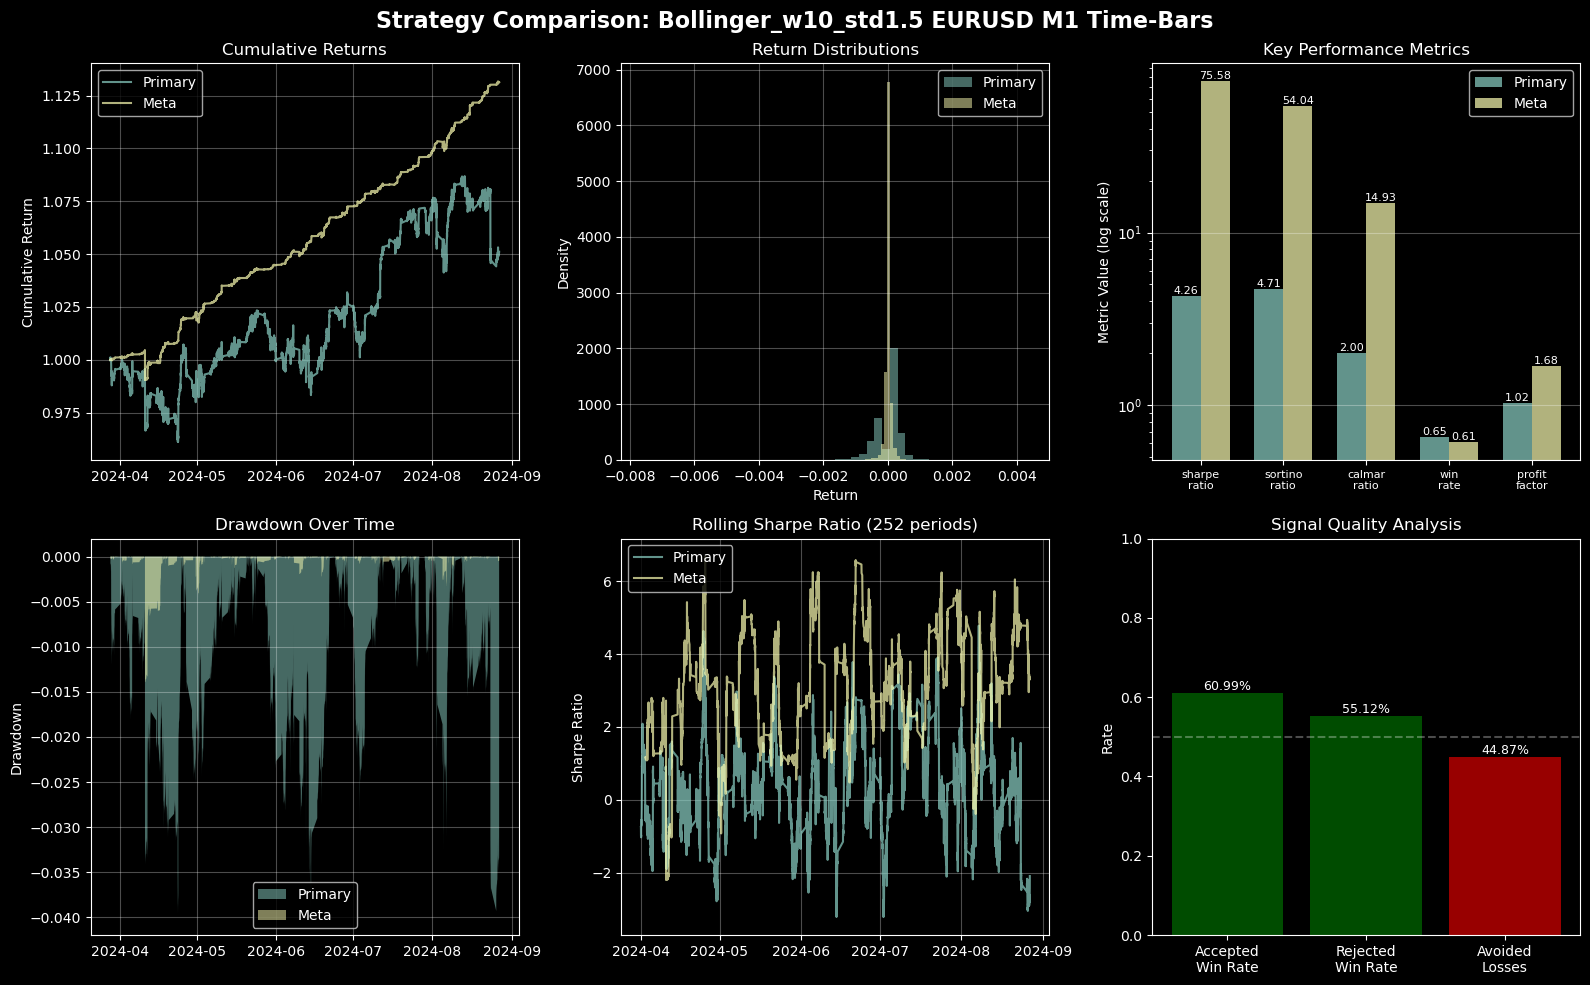

In [ ]:
bet_sizing = None
validation_metrics_by_bar_type = bet_sizing_methods[bet_sizing]
comp_fig = plot_strategy_comparison(validation_metrics_by_bar_type["time"])


In [ ]:
from afml.backtest_statistics.meta_labeling_analysis import (
    generate_complete_meta_labeling_report,
    plot_strategy_comparison,
)
validation_metrics = validation_metrics_by_bar_type["time"].copy()
dirpath = Path(
    "Meta_Labeling_Analysis", validation_metrics["strategy_name"], 
    validation_metrics["symbol"], validation_metrics["bar_size"]
    )

meta_report = generate_complete_meta_labeling_report(
    validation_metrics_by_bar_type,
    output_dir=dirpath,
    filename=f"meta_labeling_analysis_report_bet_sizing_{bet_sizing}".lower()
)


Reloading 'afml.backtest_statistics.meta_labeling_analysis'.
🔍 Generating meta-labeling analysis report...


#### Export Model to ONXX

In [ ]:
from afml.production.model_export import export_model_to_onnx

model_path = Path(r"C:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\models")
fname = f"bollinger_meta_model_{symbol}_{config['bar_type']}_{config['bar_size']}.onxx".lower()
model_path = model_path / fname
export_model_to_onnx(
    best_model.named_steps["clf"],
    feature_names=model_features,
    output_path=model_path,
    metadata=config,
)



ONNX EXPORT PIPELINE

[Step 1/5] Preparing metadata...
✓ Model type: RandomForestClassifier
✓ Features: 74
✓ Version: 1.0

[Step 2/5] Converting to ONNX format...
✓ Conversion successful
✓ ONNX opset: 12 (MQL5 compatible)

[Step 3/5] Saving ONNX model...
✓ Saved to: C:\Users\JoeN\Documents\GitHub\Machine-Learning-Blueprint\models\bollinger_meta_model_eurusd_tick_m1.onxx
✓ File size: 0.16 MB

[Step 4/5] Validating ONNX model...
✓ ONNX model structure valid

[Step 5/5] Comparing Python vs ONNX predictions...

Generating test data...
Computing Python predictions...
Computing ONNX predictions...

✓ ONNX returned 2 output(s)
  Output 0: shape=(1000,), dtype=int64
    Sample values: 1
  Output 1: shape=(1000, 2), dtype=float32
    Sample values: [0.48720157 0.5127984 ]

✓ Using output 1 (probabilities)
✓ Extracted positive class probabilities from shape (1000, 2)

Prediction Comparison (1000 samples):
  • Max difference:  1.52e-07
  • Mean difference: 4.91e-08
  • Std difference:  3.30e-08


True

### Cache Analysis

In [ ]:
# from afml.cache import clear_afml_cache

# clear_afml_cache()


In [ ]:
from afml.cache import get_cache_size_info, print_cache_health

print_cache_health()


2025-12-01 14:08:52.198 | DEBUG    | afml.cache.cache_monitoring:_get_function_cache_size:444 - Looking for cache in: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
2025-12-01 14:08:52.203 | DEBUG    | afml.cache.cache_monitoring:_get_function_cache_size:459 - Searching for patterns: ['afml_production_model_development_load_and_prepare_training_data', 'load_and_prepare_training_data']
2025-12-01 14:08:52.286 | DEBUG    | afml.cache.cache_monitoring:_get_function_cache_size:478 - Found matching cache file: func_code.py - 662 bytes
2025-12-01 14:08:52.288 | DEBUG    | afml.cache.cache_monitoring:_get_function_cache_size:478 - Found matching cache file: metadata.json - 263 bytes
2025-12-01 14:08:52.290 | DEBUG    | afml.cache.cache_monitoring:_get_function_cache_size:478 - Found matching cache file: output.pkl - 4437512 bytes
2025-12-01 14:08:52.305 | INFO     | afml.cache.cache_monitoring:_get_function_cache_size:487 - Cache size for afml.production.model_development.load_and_p


CACHE HEALTH REPORT

Overall Statistics:
  Total Functions:     6
  Total Calls:         250
  Overall Hit Rate:    80.4%
  Total Cache Size:    87.41 MB

Top Performers (by hit rate):
  1. load_and_prepare_training_data: 100.0% (50 calls)
  2. create_feature_engineering_pipeline: 100.0% (50 calls)
  3. create_bollinger_features: 100.0% (1 calls)
  4. generate_events_triple_barrier: 100.0% (50 calls)
  5. compute_sample_weights_time_decay: 100.0% (50 calls)

Worst Performers (by hit rate):
  1. create_feature_engineering_pipeline: 100.0% (50 calls)
  2. create_bollinger_features: 100.0% (1 calls)
  3. generate_events_triple_barrier: 100.0% (50 calls)
  4. compute_sample_weights_time_decay: 100.0% (50 calls)
  5. train_model_with_cv: 0.0% (49 calls)

Recommendations:
  1. Functions with low hit rate: train_model_with_cv. Review cache key generation for these functions.




In [ ]:
pprint(get_cache_size_info(), sort_dicts=False)


{'base': {'size_bytes': 695752560, 'size_mb': 663.52, 'file_count': 597},
 'joblib': {'size_bytes': 344528483, 'size_mb': 328.57, 'file_count': 68},
 'numba': {'size_bytes': 6217168, 'size_mb': 5.93, 'file_count': 164},
 'backtest': {'size_bytes': 0, 'size_mb': 0.0, 'file_count': 0}}


In [ ]:
# Detailed analysis of cache patterns
from afml.cache.cache_monitoring import analyze_cache_patterns

analyze_cache_patterns()


19:59:50 | DEBUG    | Looking for cache in: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
19:59:50 | DEBUG    | Searching for patterns: ['__main___load_data', 'load_data']
19:59:50 | DEBUG    | Found matching cache file: func_code.py - 662 bytes
19:59:50 | DEBUG    | Found matching cache file: metadata.json - 1014 bytes
19:59:50 | DEBUG    | Found matching cache file: output.pkl - 9083888 bytes
19:59:50 | DEBUG    | Found matching cache file: metadata.json - 1165 bytes
19:59:50 | DEBUG    | Found matching cache file: output.pkl - 4437488 bytes
19:59:50 | DEBUG    | Found matching cache file: metadata.json - 1016 bytes
19:59:50 | DEBUG    | Found matching cache file: output.pkl - 9083888 bytes
19:59:50 | DEBUG    | Found matching cache file: metadata.json - 1016 bytes
19:59:50 | DEBUG    | Found matching cache file: output.pkl - 17560608 bytes
19:59:50 | DEBUG    | Found matching cache file: metadata.json - 1016 bytes
19:59:50 | DEBUG    | Found matching cache file: output.pk

{'high_miss_rate_functions': [{'function': '__main__.load_data',
   'hit_rate': 0.16666666666666666,
   'calls': 24},
  {'function': 'afml.cross_validation.cross_validation.analyze_cross_val_scores',
   'hit_rate': 0.21875,
   'calls': 32},
  {'function': '__main__.train_rf',
   'hit_rate': 0.2222222222222222,
   'calls': 18}],
 'unused_caches': [],
 'large_caches': [{'function': '__main__.load_data',
   'size_mb': 298.2985153198242,
   'hit_rate': 0.16666666666666666}],
 'frequently_accessed': [],
 'optimization_candidates': []}

In [ ]:
from afml.cache import diagnose_cache_issues

# Run diagnostics
diagnose_cache_issues()



CACHE DIAGNOSTICS REPORT

1. BASIC STATS:
   Tracked functions: 4
   Total calls: 82
   Overall hit rate: 25.6%

2. CACHE EFFICIENCY:
19:59:51 | DEBUG    | Looking for cache in: C:\Users\JoeN\AppData\Local\afml\afml\Cache\joblib_cache
19:59:51 | DEBUG    | Searching for patterns: ['__main___load_data', 'load_data']
19:59:51 | DEBUG    | Found matching cache file: func_code.py - 662 bytes
19:59:51 | DEBUG    | Found matching cache file: metadata.json - 1014 bytes
19:59:51 | DEBUG    | Found matching cache file: output.pkl - 9083888 bytes
19:59:51 | DEBUG    | Found matching cache file: metadata.json - 1165 bytes
19:59:51 | DEBUG    | Found matching cache file: output.pkl - 4437488 bytes
19:59:51 | DEBUG    | Found matching cache file: metadata.json - 1016 bytes
19:59:51 | DEBUG    | Found matching cache file: output.pkl - 9083888 bytes
19:59:51 | DEBUG    | Found matching cache file: metadata.json - 1016 bytes
19:59:51 | DEBUG    | Found matching cache file: output.pkl - 17560608 bytes